# Premiers pas avec sklearn

In [1]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing

# récupération des données
housing = fetch_california_housing(as_frame=True, data_home=".")

X, y = housing.data, housing.target

## A quoi ressemblent nos données ?

L'idée ici n'est pas de faire une analyse approfondie des données, mais simplement de se familiariser avec leur structure.

In [2]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [3]:
y

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

# Comment avoir une idée de baseline : DummyRegressor

Les modèles *DummyRegressors* permettent d'avoir une idée du résultat qu'on pourrait obtenir avec un modèle très simple.

Ils nous permettent de définir une baseline, c'est-à-dire un résultat minimum que notre modèle doit dépasser pour être considéré comme pertinent.

On peut utiliser différents types de stratégies pour définir cette baseline, par exemple :
- Toujours prédire la moyenne des valeurs cibles
- Toujours prédire la médiane des valeurs cibles
- Toujours prédire une valeur constante

[sklearn.dummy.DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html)



In [17]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

# instantiation du modèle
dr = DummyRegressor(strategy="mean")

# entraînement du modèle / fit aux données : ici apprendre la moyenne
dr.fit(X, y)

# prédiction du modèle
y_pred = dr.predict(X)

# évaluation du modèle avec la MAE
mae = mean_absolute_error(y, y_pred)
print("MAE : {:.2f}".format(mae))

MAE : 0.91


# Comment faire une régression linéaire en Python avec sklearn ? 

Nous avons vu dans le premier module de ML l'intérêt de normaliser les données avant d'appliquer un modèle de régression linéaire : sans modifier la performance du modèle, cela permet d'avoir des coefficients comparables entre eux.

Sklearn permet de faire cela très facilement avec les *pipelines* : elles permettent de chaîner plusieurs étapes de traitement des données et d'entraînement du modèle en une seule ligne de code.

In [18]:
# instantiation de la pipeline en deux étapes :
# d'abord le scaling puis la régression linéaire
pipeline = make_pipeline(StandardScaler(), LinearRegression())

pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

Une fois la pipeline créée, on peut l'utiliser comme un modèle classique : on peut l'entraîner avec la méthode `fit` et faire des prédictions avec la méthode `predict`. On peut l'afficher pour voir les différentes étapes qu'elle contient et si elle a été entraînée ou non.

In [19]:
pipeline.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [20]:
from sklearn.metrics import r2_score

y_pred = pipeline.predict(X)

# évaluation avec le score r2
r2_score(y_true=y, y_pred=y_pred)

0.606232685199805

Comparons avec notre baseline

In [21]:
mae = mean_absolute_error(y, y_pred)
print("MAE : {:.2f}".format(mae))

MAE : 0.53


Chaque élément de la pipeline peut être accédé individuellement via l'attribut `named_steps`, ce qui permet d'examiner les paramètres ou les résultats intermédiaires de chaque étape.

In [22]:
pipeline[-1].coef_

array([ 0.8296193 ,  0.11875165, -0.26552688,  0.30569623, -0.004503  ,
       -0.03932627, -0.89988565, -0.870541  ])

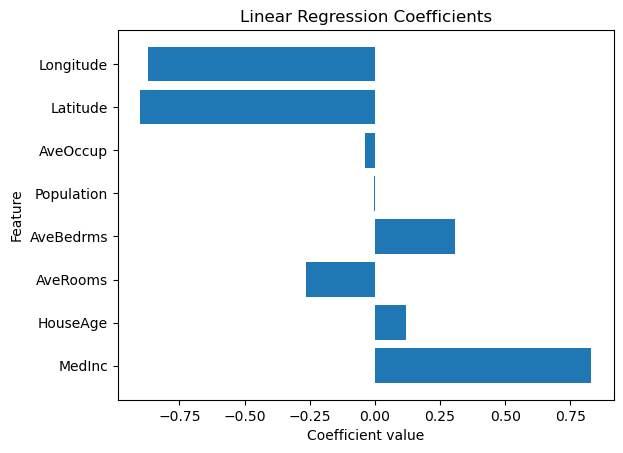

In [23]:
# plot des coefficients de la régression
import matplotlib.pyplot as plt

plt.barh(housing.feature_names, pipeline[-1].coef_)
plt.xlabel("Coefficient value")
plt.ylabel("Feature")
plt.title("Linear Regression Coefficients")
plt.show()

# Pour pouvoir évaluer la capacité de généralisation du modèle : train test split

Nous avons vu la théorie en cours : pour évaluer la capacité de généralisation d'un modèle, il est important de le tester sur des données qu'il n'a pas vues pendant son entraînement.

Nous allons utiliser la fonction `train_test_split` de sklearn pour diviser notre jeu de données en un ensemble d'entraînement et un ensemble de test.

C'est ici que la `pipeline` est très utile : elle permet de s'assurer que les transformations appliquées aux données d'entraînement sont également appliquées aux données de test, sans risque de fuite de données entre ensemble d'entraînement et de test **(data leakage)** : les statistiques de normalisation (mean, std) sont calculées uniquement sur les données d'entraînement, puis appliquées aux données de test.

In [27]:
from sklearn.model_selection import train_test_split

# split des données en train et test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)  # pour la reproductibilité

# réinstantiation de la pipeline et entraînement sur les données d'entraînement
pipeline = make_pipeline(StandardScaler(), LinearRegression())
pipeline.fit(X_train, y_train)

# prédiction sur les deux sets
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# évaluation avec la mae
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("MAE train : {:.5f}".format(mae_train))
print("MAE test : {:.5f}".format(mae_test))

MAE train : 0.52952
MAE test : 0.52970


Ici les deux sont très proches : c'est bon signe ! 

# God mode : cross validation

Pour aller plus loin, on peut utiliser la cross-validation pour évaluer la performance du modèle de manière plus robuste. La cross-validation consiste à diviser les données en plusieurs sous-ensembles (folds), puis à entraîner et évaluer le modèle sur chacun de ces sous-ensembles.



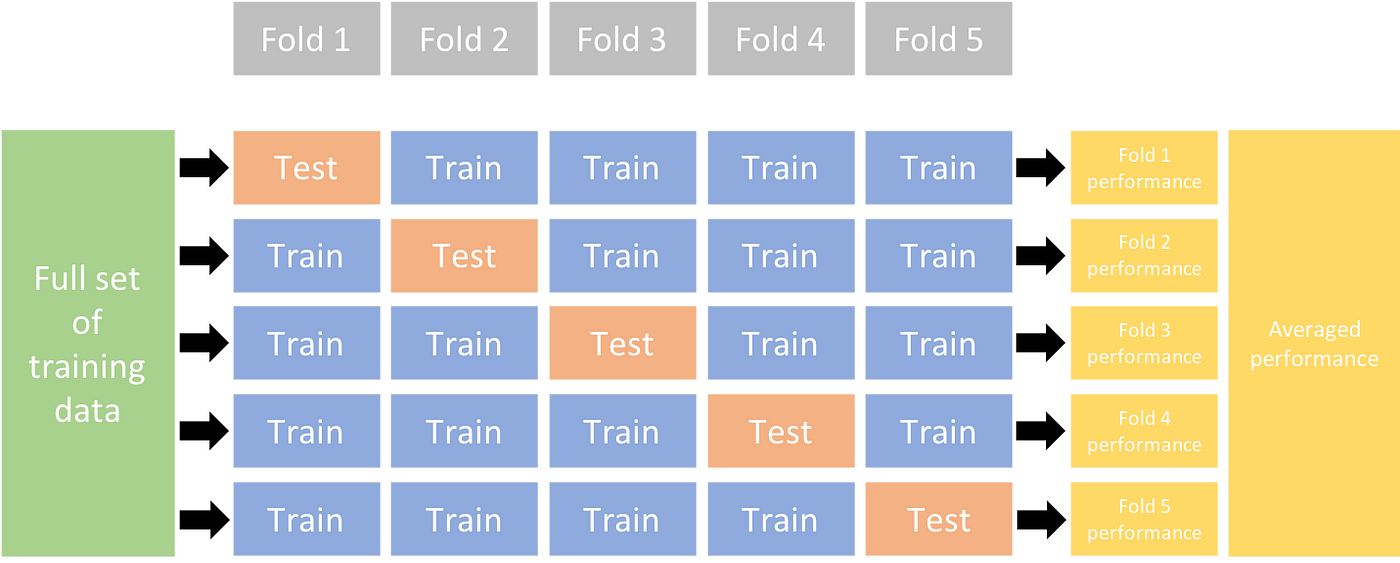

In [29]:
from sklearn.model_selection import cross_validate, RepeatedKFold
import numpy as np

# création d'un schéma de cross-validation : Repeated K-Fold, on fait 5 folds, répétés 5 fois avec des splits différents
cv = RepeatedKFold(n_splits=5, n_repeats=5)

# cross_validate retourne un dictionnaire
scores = cross_validate(
    pipeline,
    X,
    y,
    n_jobs=4,
    scoring="neg_mean_squared_error",
    cv=cv,
    return_train_score=True,
)

# calcul des erreurs moyennes
train_mse = -np.mean(scores["train_score"])
test_mse = -np.mean(scores["test_score"])

# calcul des écarts-types
train_std = np.std(scores["train_score"])
test_std = np.std(scores["test_score"])

print("Cross-validated Train MSE: {:.5f} +/- {:.5f}".format(train_mse, train_std))
print("Cross-validated Test MSE: {:.5f} +/- {:.5f}".format(test_mse, test_std))

Cross-validated Train MSE: 0.52390 +/- 0.00477
Cross-validated Test MSE: 0.52988 +/- 0.02192
